# Model Training and Evaluation on Agricultural Pest Images

This notebook explores the application of both classical machine learning and state-of-the-art deep learning methods for multi-class classification of agricultural pest images.

## Problem Statement

The accurate identification of agricultural pests is critical for improving crop yield and minimizing environmental damage associated with overuse of pesticides. Manual inspection is prone to error and does not scale for large agricultural regions. The goal of this project is to evaluate several modeling strategies for robust automatic pest recognition based on image data.

## Dataset Description

The dataset contains thousands of color images representing 12 different pest classes, collected from a range of agricultural environments. Each image is labeled with its corresponding pest type. The dataset is realistic, varies in quality, and involves challenges such as class imbalance and intra-class variability.

## Workflow Plan

- Conduct thorough data loading, cleaning, and stratified splitting to ensure reproducible experiments.
- Benchmark classical ML models (Logistic Regression, SVM, Random Forest) on extracted or flattened features.
- Design and train baseline CNN and custom CNN architectures from scratch to establish deep learning baselines.
- Apply transfer learning (VGG16 and MobileNetV2), including fine-tuning, to leverage high-level feature representations.
- Evaluate each model using accuracy, precision, recall, F1 score, validation curves, confusion matrices, and ROC curves.
- Summarize results in comparative tables and critically discuss limitations, tradeoffs, and real-world implications.

This end-to-end pipeline demonstrates a scientific, evidence-driven approach to pest detection, providing both technical insights and practical recommendations for AI in agricultural applications.

# data source:https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset?resource=download

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


''

#Library Imports

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download, unzip, and list dataset.

In [ ]:
# Download the file from Google Drive
!gdown --id 1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU

# Define the target directory
target_dir = '/content/pestpredicition'

# Create the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Unzip the downloaded file into the target directory
!unzip archive.zip -d {target_dir} >/dev/null 2>&1

# List the contents of the unzipped directory
!ls {target_dir}

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU
From (redirected): https://drive.google.com/uc?id=1Q8x9jqPWFGTOoxMEMmJ-eMAJwdEIofEU&confirm=t&uuid=3f1abc61-f802-4785-a146-58f85f6c2309
To: /content/archive.zip
100% 107M/107M [00:01<00:00, 71.1MB/s] 
ants  beetle	    earthworms	grasshopper  slug   wasp
bees  catterpillar  earwig	moth	     snail  weevil


In [ ]:
DATA_DIR = '/content/pestpredicition'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
OUTPUT_DIR = '/content/output'

#  1.Data Preprocessing and Splitting

In [ ]:
# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 2. Load and Preprocess Data
def load_and_preprocess_data(data_dir, img_size):
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0
                images.append(img)
                labels.append(label_map[class_name])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names

print("Loading and preprocessing data...")
images, labels, class_names = load_and_preprocess_data(DATA_DIR, IMG_SIZE)
print(f"Loaded {len(images)} images from {len(class_names)} classes.")

# --- Split Data ---
X_flat = images.reshape(images.shape[0], -1)
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, labels, test_size=0.3, random_state=42, stratify=labels)
X_train, X_test, y_train_dl, y_test_dl = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test_dl, y_val_dl, y_test_dl_final = train_test_split(X_test, y_test_dl, test_size=0.5, random_state=42, stratify=y_test_dl)


Loading and preprocessing data...
Loaded 5494 images from 12 classes.


# 2. Visualization Helpers

In [ ]:
def plot_learning_curves(history, model_name, experiment, test_metrics=None):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    if test_metrics:
        plt.axhline(y=test_metrics['accuracy'], color='r', linestyle='--', label=f'Test Accuracy ({test_metrics["accuracy"]:.4f})')
    plt.title(f'{model_name} ({experiment}) - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if test_metrics:
        plt.axhline(y=test_metrics['loss'], color='r', linestyle='--', label=f'Test Loss ({test_metrics["loss"]:.4f})')
    plt.title(f'{model_name} ({experiment}) - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_learning_curves.png'))
    plt.show()
    plt.close()

def plot_confusion_matrix(y_true, y_pred, model_name, experiment):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} ({experiment}) - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_confusion_matrix.png'))
    plt.show()
    plt.close()

def plot_roc_curves(y_true, y_pred_proba, model_name, experiment, n_classes):
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ({experiment}) - ROC Curves')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_roc_curves.png'))
    plt.show()
    plt.close()

def plot_classical_performance_curves(train_metrics, test_metrics, model_name, experiment):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    train_values = [train_metrics[m] for m in metrics]
    test_values = [test_metrics[m] for m in metrics]

    plt.figure(figsize=(10, 6))
    plt.plot(metrics, train_values, marker='o', linestyle='-', label='Train')
    plt.plot(metrics, test_values, marker='o', linestyle='-', label='Test')

    plt.title(f'{model_name} ({experiment}) - Performance Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()

    for i, metric in enumerate(metrics):
        plt.text(i, train_values[i] + 0.02, f'{train_values[i]:.4f}', ha='center')
        plt.text(i, test_values[i] - 0.04, f'{test_values[i]:.4f}', ha='center')

    plt.savefig(os.path.join(OUTPUT_DIR, f'{model_name}_{experiment}_performance_curves.png'))
    plt.show()
    plt.close()

In [ ]:
n_classes = len(class_names)

In [ ]:
# 5. Deep Learning Models
input_shape = X_train[0].shape
num_classes = len(class_names)
y_train_cat = to_categorical(y_train_dl, num_classes)
y_val_cat = to_categorical(y_val_dl, num_classes)
y_test_cat = to_categorical(y_test_dl_final, num_classes)

In [ ]:
def create_transfer_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    return Sequential([base_model, Flatten(), Dense(512, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')])

# Deep Learning Models MobileNetV2 Experiment 13

In [ ]:
# --- Data Augmentation and Callbacks (Exp4) ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


--- Training Transfer Learning (MobileNetV2) with Fine-Tuning (Exp4) ---

Phase 1: Training the classifier head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 106s 825ms/step - accuracy: 0.4062 - loss: 2.4004 - val_accuracy: 0.7706 - val_loss: 0.7159 - learning_rate: 1.0000e-04
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 152s 913ms/step - accuracy: 0.6700 - loss: 1.0488 - val_accuracy: 0.7767 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 97s 800ms/step - accuracy: 0.6969 - loss: 0.9070 - val_accuracy: 0.7828 - val_loss: 0.6572 - learning_rate: 1.0000e-04
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 96s 794ms/step - accuracy: 0.7158 - loss: 0.8439 - val_accuracy: 0.8107 - val_loss: 0.6026 - learning_rate: 1.0000e-04
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 92s 762ms/step - accuracy: 0.7406 - loss: 0.7788 - val_accuracy: 0.8034 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 141s 750ms/step - accuracy: 0.7665 - loss: 0.7160 - val_accuracy: 0.7973 - val_loss: 0.6257 - learning_rate: 1.0000e-04
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 101

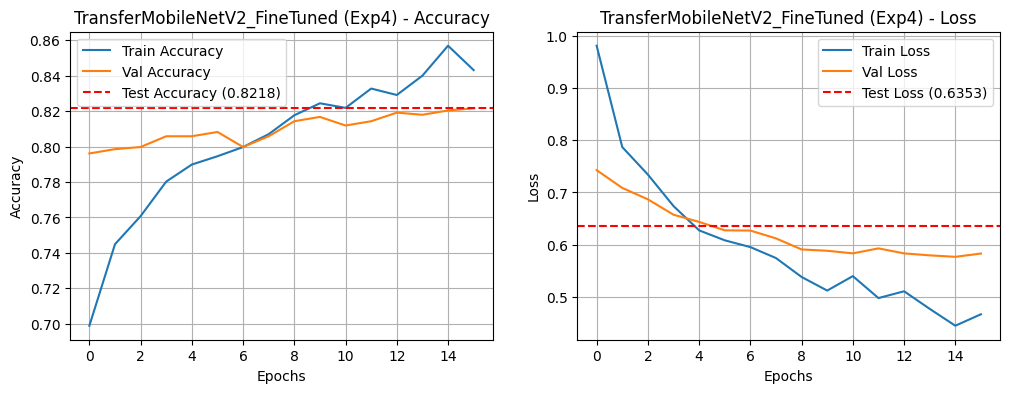

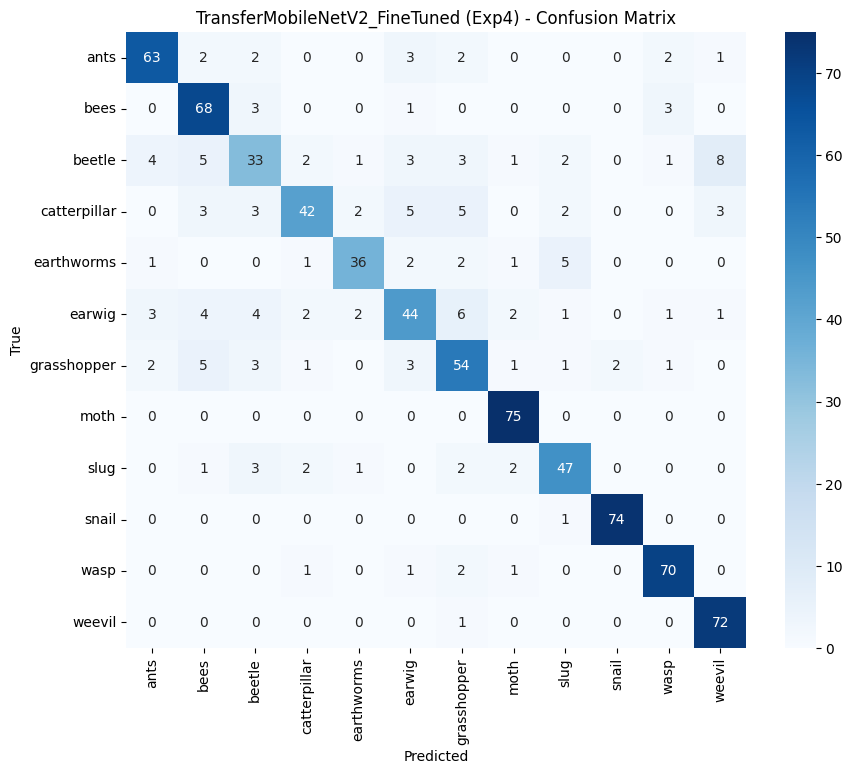

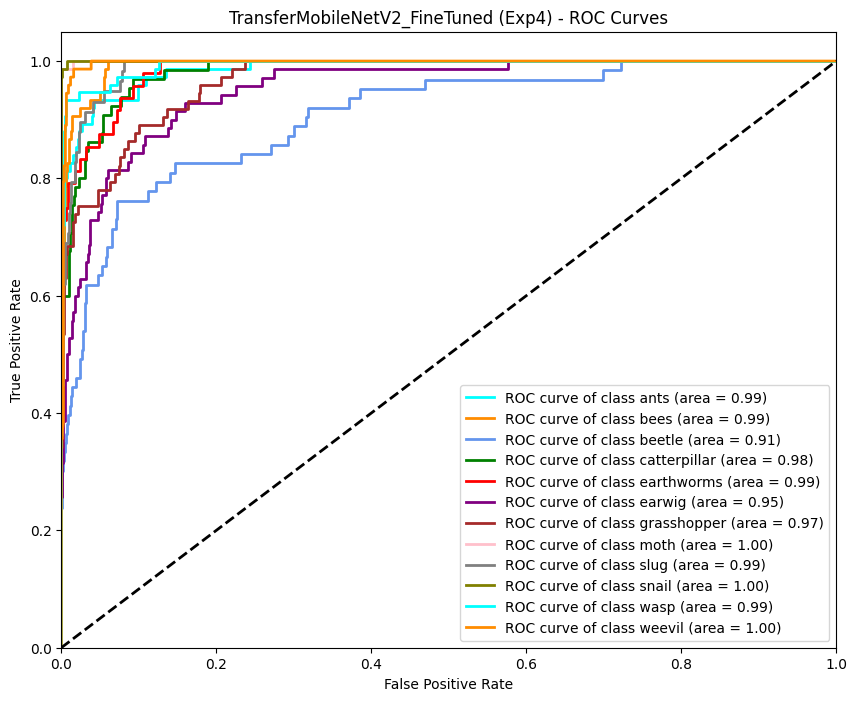


Script finished. Plots are saved in the 'output' directory.


In [ ]:
# --- Experiment 4: Fine-Tuning the MobileNetV2 Model ---
print("\n--- Training Transfer Learning (MobileNetV2) with Fine-Tuning (Exp4) ---")

# For fine-tuning, it's best to first train the classifier head and then unfreeze the base model.
# This experiment will be self-contained and perform both steps.

# Step 1: Create a new model for this experiment
finetune_model = create_transfer_mobilenet_model(input_shape, num_classes)

# Step 2: Train the top layer (the classifier)
print("\nPhase 1: Training the classifier head")
finetune_model.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Train for a number of epochs to stabilize the classifier weights
head_epochs = 15
history_phase1 = finetune_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=int(np.ceil(len(X_train) / BATCH_SIZE)),
    epochs=head_epochs,
    callbacks=[early_stopping, reduce_lr], # Use original callbacks for this phase
    verbose=1
)

# Step 3: Unfreeze the base model and fine-tune
print("\nPhase 2: Fine-tuning the model")
base_model = finetune_model.layers[0]
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100  # Unfreeze the top 54 layers

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning
finetune_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(f"Fine-tuning model by unfreezing top {len(base_model.layers) - fine_tune_at} layers.")

# Continue training for more epochs to fine-tune the unfrozen layers
fine_tune_epochs = 15
total_epochs = head_epochs + fine_tune_epochs

history_mb4 = finetune_model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val_cat),
    steps_per_epoch=int(np.ceil(len(X_train) / BATCH_SIZE)),
    epochs=total_epochs,
    initial_epoch=history_phase1.epoch[-1], # Start counting epochs after the head training
    callbacks=[early_stopping, reduce_lr], # Can reuse the same callbacks
    verbose=1
)

# Evaluation
loss_mb4, acc_mb4 = finetune_model.evaluate(X_test_dl, y_test_cat, verbose=0)
preds_proba_mb4 = finetune_model.predict(X_test_dl)
preds_mb4 = np.argmax(preds_proba_mb4, axis=1)

print("\n--- Experiment 4 (Fine-Tuning) Test Results ---")
print(f"Loss: {loss_mb4:.4f}")
print(f"Accuracy: {acc_mb4:.4f}")
print(f"Precision: {precision_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test_dl_final, preds_mb4, average='weighted'):.4f}")

# Plotting Results
plot_learning_curves(history_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4', test_metrics={'accuracy': acc_mb4, 'loss': loss_mb4})
plot_confusion_matrix(y_test_dl_final, preds_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4')
plot_roc_curves(y_test_dl_final, preds_proba_mb4, 'TransferMobileNetV2_FineTuned', 'Exp4', num_classes)

print("\nScript finished. Plots are saved in the 'output' directory.")

In [ ]:
model_save_path_exp4 = os.path.join(OUTPUT_DIR, 'mobilenetv2_finetuned_model_exp4.keras')
finetune_model.save(model_save_path_exp4)
print(f"MobileNetV2 fine-tuned model from Experiment 4 saved to: {model_save_path_exp4}")

MobileNetV2 fine-tuned model from Experiment 4 saved to: /content/output/mobilenetv2_finetuned_model_exp4.keras
